In [16]:
import earthaccess                    # Acesso aos dados da NASA (Earthdata)
import xarray as xr                   # Manipulação de dados multidimensionais
import netCDF4                        # Suporte a arquivos NetCDF
import h5py                           # Leitura de arquivos HDF5
import h5netcdf                       # Engine para ler HDF5 como NetCDF
import numpy as np                    # Operações numéricas
import matplotlib.pyplot as plt       # Criação de gráficos
import cartopy.crs as ccrs            # Projeções cartográficas
from cartopy.mpl.gridliner import (LONGITUDE_FORMATTER, LATITUDE_FORMATTER)
import matplotlib.ticker as mticker   # Controle de ticks nos eixos
from matplotlib.colors import BoundaryNorm  # Normalização de cores

%matplotlib inline

In [22]:
# Realiza login no Earthdata para permitir download dos dados
auth = earthaccess.login()

# Busca os granules do produto GPM IMERG Monthly (V07)
results = earthaccess.search_data(
    short_name="GPM_3IMERGM",  # Produto IMERG mensal
    version="07",               # Versão científica
    temporal=('2025-01-01', '2025-01-01'),  # Período de interesse
    bounding_box=(-180, 0, 180, 90) # Hemisfério Norte
)

print(results)

# Faz o download dos arquivos encontrados
downloaded_files = earthaccess.download(
    results,
    local_path='..', # Diretório onde os arquivos serão salvos
)

[Collection: {'ShortName': 'GPM_3IMERGM', 'Version': '07'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-01-01T00:00:00.000Z', 'EndingDateTime': '2025-01-31T23:59:59.999Z'}}
Size(MB): 17.2589101791382
Data: ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGM.07/2025/3B-MO.MS.MRG.3IMERG.20250101-S000000-E235959.01.V07B.HDF5']]


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# Caminho do primeiro arquivo baixado
path = str(downloaded_files[0])
# Abre o dataset usando o grupo "Grid" do arquivo HDF5
ds = xr.open_dataset(path, group="Grid", engine="h5netcdf")
ds

<xarray.Dataset> Size: 130MB
Dimensions:                         (time: 1, nv: 2, lon: 3600, lonv: 2,
                                     lat: 1800, latv: 2)
Coordinates:
  * time                            (time) object 8B 2025-01-01 00:00:00
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
Dimensions without coordinates: nv, lonv, latv
Data variables:
    time_bnds                       (time, nv) object 16B ...
    lon_bnds                        (lon, lonv) float32 29kB ...
    lat_bnds                        (lat, latv) float32 14kB ...
    precipitation                   (time, lon, lat) float32 26MB ...
    randomError                     (time, lon, lat) float32 26MB ...
    gaugeRelativeWeighting          (time, lon, lat) float32 26MB ...
    probabilityLiquidPrecipitation  (time, lon, lat) float32 26MB ...
    precipitationQualityIndex       (time, lon, lat) float32 26MB ...
Attributes:
    GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatitudeRe...

In [25]:
# Seleciona a precipitação do primeiro mês (Janeiro de 2014)
precip = ds['precipitation'][0,:,:].values
# Transpõe a matriz para alinhar com longitude e latitude
precip = np.transpose(precip)
# Extrai os vetores de latitude e longitude
theLats = ds['lat'].values
theLons = ds['lon'].values
# Cria a grade espacial (longitude x latitude)
x, y = np.float32(np.meshgrid(theLons, theLats))

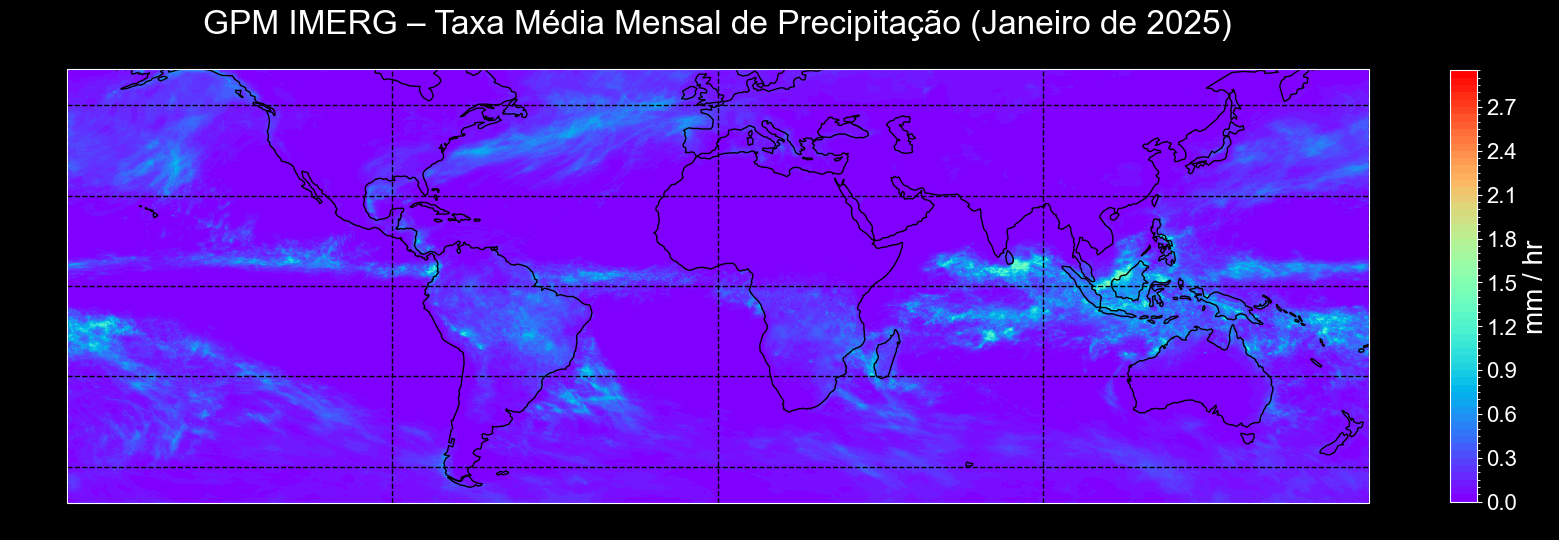

In [27]:
# Cria a figura e define a projeção cartográfica
fig = plt.figure(figsize=(21, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
# Define a área exibida no mapa
ax.set_extent([-180, 180, -60, 60])

# Adiciona linhas de costa
ax.coastlines(resolution="110m", linewidth=1)
# Adiciona linhas de latitude e longitude com rótulos
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
# Define os intervalos das linhas da grade
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.ylocator = mticker.FixedLocator([-60, -50, -25, 0, 25, 50, 60])

# Formatação dos rótulos
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}

# Define os níveis de precipitação (mm/h)
clevs = np.arange(0, 3, 0.05)

# Normaliza os valores de acordo com os níveis definidos
norm = BoundaryNorm(clevs, ncolors=plt.cm.rainbow.N, clip=True)

# Plota a precipitação no mapa
mesh = plt.pcolormesh(x, y, precip, cmap=plt.cm.rainbow, norm=norm, shading="auto")


cb = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.05, aspect=16, shrink=0.8)
cb.set_label('mm / hr', size=20)
cb.ax.tick_params(labelsize=16)


plt.title('GPM IMERG – Taxa Média Mensal de Precipitação (Janeiro de 2025)', size=24)


plt.show()